# 1.Background（背景）

临床结局一般是多因素共同作用的结果，在模型构建时，变量间常存在各种各样的关系，单因素分析由于无法考虑各变量之间的关系，结果往往不可靠，我们常常采用的解决方案是多因素的回归分析。在进行多因素的回归分析时，如何合理地进行变量筛选从而构建最佳模型是不可避免的问题。

# 2.筛选方法和函数

Bestsubset_survivalWhen we build a prediction model, in nature, what we would like to do is to find a function $f()$ to make $Y=f(\mathbf{X}, \epsilon)$. The function $f()$ can be enumerous. Thus, The key step of prediction model building is to make some reasonable assumptions about the function form of $f()$, and these assumptions are called the hypothesis space of $f()$.

当我们构建预测模型时，我们想去找到一个函数 $f()$ 使得 $Y=f(\mathbf{X}, \epsilon)$，函数 $f()$ 是多种多样的。因此，构建预测模型的关键步骤是对 $f()$ 的函数形式做出一些合理的假设，这些假设就称为 $f()$ 的假设空间。

Hypothesis space of linear function ($f(\mathbf{X}, \epsilon)=\mathbf{X} \cdot \beta^{T} + \epsilon$)


线性函数的假设空间为 $f(\mathbf{X}, \epsilon)=\mathbf{X} \cdot \beta^{T} + \epsilon$。

## 2.1 Without additional restrictions（无额外限制的变量筛选方法）

When we assume the hypothesis space is a space of linear function without any additional restriction. The key question now is to find the optimal combination of candicate predictors from the candidate predictor pool. During the process of finding the optimal combination, we have different searching strategies, each one of them is only a trade-off between complexity and best optimism. Basically, there are two types of searching strategies as follows.

当我们假定该假设空间是一个无额外限制的线性函数空间时，关键问题就是从预测变量池中寻找候选预测变量的最佳组合。我们在寻找最佳模型的过程中有不同的模型变量筛选方法，但每一种方法仅是对模型复杂性和最优组合之间的权衡。以下将介绍两种常见的模型变量筛选方法
>- 最优子集筛选法（best subset selection）
>- 逐步选择法（stepwise selection）
>>- 前进法（forward stepwise selection）
>>- 后退法（backward stepwise selection）

### 2.1.1 最优子集法（Best subset selection）

1. Let $M_{0}$ denote the null model, which contains no predictors;
2. For $k = 1, 2, \cdots, p$
>- Fit all ${p \choose k}$ models that contain exactly $k$ predictors;
>- Pick the best among these ${p \choose k}$ models, and call it $M_{k}$; Here <span style="color:red">best</span> is defined as having the smallest deviance ($D=-2l(0)$, for linear model, deviance is equal to residual sum of squares [RSS]), or equivalently the largest $R^{2}$ (coefficient of determination, $R^{2}=1-\frac{SSR}{SST}$, generalized $R^{2}=1-(\frac{l(0)}{l(\hat{\beta})})^{2/n}$);
3. Select a single best model from among $M_{0}, \cdots, M_{p}$ using cross-validated prediction error, AIC, BIC, ... .

1. 记 $M_{0}$ 为空模型，该模型中无预测变量，只存在截距项；
2. 对于 $k = 1, 2, \cdots, p$：
>- 选取所有 ${p \choose k}$ 个包含k个自变量的模型进行拟合；
>- 从 ${p \choose k}$ 个模型中选择最优模型，记为$M_{k}$（因为${p \choose k}$个模型的自变量数均为k，所以此处最优模型可以通过最小的方差（$D=-2l(0)$）或最大的 $R^{2}$ 选取）；
3. 从 $M_{0}, \cdots, M_{p}$ 中选择一个最优模型，选取标准包括交叉验证的预测误差、AIC、BIC等。

In [1]:
# Install required packages and library them
packages <- c("survival",
              "survMisc",
              "plyr",
              "dplyr",
              "glmnet")

for (i in packages) {
    if (!suppressMessages(require(i, character.only = TRUE, quietly = TRUE))) {
        install.packages(i, quietly = TRUE)
    }
}

In [2]:
# 定义函数
# best subset
Bestsubset_survival <- function(dataset, time, status, predictors, best_criteria = "R2"){
    survival_outcome <- Surv(dataset[,time], dataset[,status])
    list_of_reg_formulas <- lapply(seq_along((predictors)), function(n) {
        left_hand_side  <- paste("Surv(", time, ", ", status, ")", sep ="")
        right_hand_side <- apply(X = combn(predictors, n), MARGIN = 2, paste, collapse = " + ")
        paste(left_hand_side, right_hand_side, sep = "  ~  ")
    })
    vector_of_reg_formulas <- unlist(list_of_reg_formulas)
    
    options(warn = -1)
    list_of_reg_fits <- lapply(vector_of_reg_formulas, function(x) {
        formula <- as.formula(x)
        fit <- coxph(formula, data = dataset)
        result_R2 <- summary(fit)$rsq
        result_AIC <- extractAIC(fit)
        
        data.frame(No_predictors = result_AIC[1],
                   R2 = result_R2[1], 
                   AIC = result_AIC[2],
                   model = x)
    })
    options(warn = 0)
    
    res <- do.call(rbind, list_of_reg_fits)
    if (best_criteria == "R2"){
        formula <- res %>% 
            group_by(No_predictors) %>% 
            mutate(best_model = (R2 == max(R2))) %>% 
            filter(best_model) %>% 
            ungroup() %>% 
            mutate(model = as.character(model), optimal_model = (AIC == min(AIC))) %>% 
            filter(optimal_model) %>% 
            '[['('model')
    }
    if (best_criteria == "AIC"){
        formula <- res %>% 
            group_by(No_predictors) %>% 
            mutate(best_model = (AIC == min(AIC))) %>% 
            filter(best_model) %>% 
            ungroup() %>% 
            mutate(model = as.character(model), optimal_model = (AIC == min(AIC))) %>% 
            filter(optimal_model) %>% 
            '[['('model')
    }
    return(formula)
}

### 2.1.2 逐步选择法（stepwise selection）

#### （1）前进法

1. 记 $M_{0}$ 为空模型，该模型中无预测变量，只存在截距项；
2. 对于 $k = 0, 1, \cdots, p-1$：
>- 拟合所有在 $M_{k}$ 模型基础上加入1个自变量的模型（共有$p-k$个模型）；
>- 从 $p-k$ 个模型中选取 $R^{2}$ 最大的模型，记为$M_{k+1}$；
3. 从 $M_{0}, \cdots, M_{p}$ 中选择一个最优模型，选取标准包括交叉验证的预测误差、AIC、BIC等。

In [3]:
# Forwardstep
Forwardstep_survival <- function(dataset, time, status, predictors){
    selected_vars <- c()
    models <- data.frame()
    p <- length(predictors)
    survival_outcome <- Surv(dataset[,time], dataset[,status])
    
    # null model(初始model) 
    null_model <- coxph(
                as.formula(paste("Surv(", time, ", ", status, ") ~ ",
                                 "1", 
                                 sep = "")),
                data = dataset) 
    result_R2 <- NA
    result_AIC <- extractAIC(null_model)
    models <- data.frame(
                     No_predictors = result_AIC[1],
                     R2 = NA,
                     AIC = result_AIC[2])

    for (k in 0:(p-1)) {
        candidate_added_vars  <- setdiff(predictors, selected_vars)
        # Generate p-k model by adding another predictor
        results <- lapply(candidate_added_vars, function(x) {
            formula <- paste("Surv(", time, ", ", status, ") ~ ", 
                             paste(c(x, selected_vars),
                                   collapse = " + "), sep = "")
            fit <- coxph(as.formula(formula), data = dataset)
            result_R2 <- summary(fit)$rsq
            result_AIC <- extractAIC(fit)
            data.frame(No_predictors = result_AIC[1],
                        R2 = result_R2[1],
                        AIC = result_AIC[2],
                        added_var = x,
                        formula = formula)
        })
        res <- do.call(rbind, results)
        best_model <- res %>% 
                        mutate(best_model = (R2 == max(R2))) %>% 
                        filter(best_model)
        added_var <-  best_model %>% '[['('added_var')
        selected_vars <- c(selected_vars, added_var)
        best_model$model_vars <- paste(selected_vars, collapse = " + ")
        models <- rbind.fill(models, best_model)
    }
    
    train_model_forwardstep <- models[models$AIC == min(models$AIC),][,"formula"]
    return(train_model_forwardstep)
}

#### （补充）带有停止准则的前进法

1. Let $M_{0}$ denote the null model, which contains no predictors; Let $M_{p}$ denote the full model, which contains all $p$ predictors;

2. Repeat the following steps for $k = 1, \cdots, p$ :
>- Fit all $p-k+1 \choose 1$ models by adding another predictor to model $M_{k-1}$;
>- Pick the best model, call it $M_k$; Here <span style="color:red">best</span> is defined as having the smallest deviance ($D=-2l(0)$, for linear model, deviance is equal to residual sum of squares [RSS]), or equivalently the largest $R^{2}$ (coefficient of determination, $R^{2}=1-\frac{SSR}{SST}$, generalized $R^{2}=1-(\frac{l(0)}{l(\hat{\beta})})^{2/n}$); or the samllest cross-validated prediction error, or the samllest AIC ($-2l(\hat{\beta} + 2k$), or the samllest BIC($-2l(\hat{\beta} + klog(n)$), ...
>- Select a single best model between $M_{k-1}$ and $M_{k}$; 
>- Stop if the single best model is $M_{k-1}$ or $k = p$;

3. The final model is $M_{k-1}$ or $M_{p}$.


1.定义$M_{0}$为空模型，不含任何预测变量；定义$M_{p}$为全模型，含有全部 $p$ 个预测变量；

2.对于 $k = 1,\cdots, p$，重复以下步骤：
    
>- 通过为模型 $M_{k-1}$添加1个预测变量，拟合所有的$p-k+1 \choose 1$ 个模型
>- 选择最优模型，记为$M_{k}$；此处最优模型可以通过最小的方差[$D=-2l(0)$，对于线性模型而言，方差等同于残差平方和(RSS)]，或最大的 $R^{2}$ [决定系数, $R^{2}=1-\frac{SSR}{SST}$, 广义 $R^{2}=1-(\frac{l(0)}{l(\hat{\beta})})^{2/n}$]，或最小的交叉验证的预测误差，或最小的AIC[$-2l(\hat{\beta} + 2k$]，或最小的BIC[$-2l(\hat{\beta} + klog(n)$]选取...
>- 从 $M_{k-1}$和$M_{k}$之间选择一个最好的模型；
>- 当该模型是$M_{k-1}$或$k = p$的时候，停止该过程；

3.最终的模型为$M_{k-1}$ 或 $M_{p}$。

In [4]:
# Forwardstep with stop criteria(也可以用step()函数)
ForwardstepwithStop_survival <- function(dataset, time, status, predictors){
    selected_vars <- c()
    p <- length(predictors)
    null_model <- coxph(as.formula(
                        paste("Surv(", time, ", ", status, ") ~ ", 
                              "1", 
                              sep = "")),
                        data = dataset) # null model
    result_R2 <- NA
    AIC_min <- extractAIC(null_model)[2]
    
    for (k in 1:p) {
        candidate_added_vars  <- setdiff(predictors, selected_vars)
        # Generate p-k+1 model by adding another predictor
        results <- lapply(candidate_added_vars, function(x){
            formula <- paste("Surv(", time, ", ", status, ") ~ ", 
                             paste(c(x, selected_vars),
                                   collapse = " + "), sep = "")
            fit <- coxph(as.formula(formula), data = dataset)
            result_R2 <- summary(fit)$rsq
            result_AIC <- extractAIC(fit)
            data.frame(
                No_predictors = result_AIC[1],
                R2 = result_R2[1],
                AIC = result_AIC[2],
                added_var = x,
                formula = formula)
        })
        res <- do.call(rbind, results)

        if (min(res$AIC) < AIC_min) { 
            added_var <- res %>% 
                    mutate(best_model = (AIC == min(AIC))) %>% 
                    filter(best_model) %>% 
                    '[['('added_var')
            selected_vars <- c(selected_vars, added_var)
            k = k + 1
            AIC_min <- min(res$AIC)
        } else {
            break 
            # Stop if the single best model is $M_{k-1}$
        }
    }
    final_model <- paste("Surv(", time, ", ", status, ") ~ ", 
                         paste(selected_vars, collapse = " + "), 
                         sep = "")
    return(final_model)
}

#### （2）后退法

1. 记 $M_{p}$ 为包含所有自变量的全模型；
2. 对于 $k = p, p-1, \cdots, 1$：
>- 拟合所有在 $M_{k}$ 模型基础上减少1个自变量的模型（共有$k$个模型）；
>- 从$k$个模型中选取 $R^{2}$ 最大的模型，记为$M_{k-1}$；
3. 从 $M_{0}, \cdots, M_{p}$ 中选择一个最优模型，选取标准包括交叉验证的预测误差、AIC、BIC等。

In [5]:
# Backwardstep
Backwardstep_survival <- function(dataset, time, status, predictors){
    selected_vars <- predictors
    models <- data.frame()
    p <- length(predictors)
    # full model(初始model) 
    full_model <- coxph(
                as.formula(paste("Surv(", time, ", ", status, ") ~ ",
                                 paste(predictors, collapse = "+"), 
                                 sep = "")),
                data = dataset)
    result_R2 <- summary(full_model)$rsq
    result_AIC <- extractAIC(full_model)
    models <- data.frame(
                 No_predictors = result_AIC[1],
                 R2 = result_R2[1],
                 AIC = result_AIC[2])
    
    for (k in p:1) {
        if (k == 1) {
            null_model <- coxph(
                            as.formula(paste("Surv(", time, ", ", status, ") ~ ",
                                             "1", 
                                             sep = "")),
                            data = dataset) # null model
            result_R2 <- NA
            result_AIC <- extractAIC(null_model)
            best_model <- data.frame(
                                 No_predictors = result_AIC[1],
                                 R2 = NA,
                                 AIC = result_AIC[2])
            models <- rbind.fill(models, best_model)
        }
        if (k > 1) {
            # Generate k model by remove a predictor
            candidate_vars <- selected_vars
            
            results <- lapply(candidate_vars, function(x){
                formula <- paste("Surv(", time, ", ", status, ") ~ ",
                                 paste(setdiff(selected_vars, x), collapse = " + "), 
                                 sep = "")
                fit <- coxph(as.formula(formula), data=dataset)
                result_R2 <- summary(fit)$rsq
                result_AIC <- extractAIC(fit)

                data.frame(No_predictors = result_AIC[1],
                            R2 = result_R2[1], 
                            AIC = result_AIC[2],
                            dropped_var = x,
                            formula = as.character(formula))
            })

            res <- do.call(rbind, results)
            best_model <- res %>% 
                            mutate(best_model = (R2 == max(R2))) %>% 
                            filter(best_model)
            dropped_var <-  best_model %>% '[['('dropped_var')
            selected_vars <- setdiff(selected_vars, dropped_var)
            best_model$model_vars <- paste(selected_vars, collapse = " + ")
            models <- rbind.fill(models, best_model)
        }
    }

    train_model_backwardstep <- models[models$AIC == min(models$AIC),][,"formula"]
    return(train_model_backwardstep)
}

#### （补充）带有停止准则的后退法

1. Let $M_{p}$ denote the full model, which contains all $p$ predictors; Let $M_{0}$ denote the null model, which contains no predictors;

2. Repeat the folloing steps for $k = p, \cdots, 1$:

>- Fit all $k \choose 1$ models by dropping one predictor from model $M_{k}$;
>- Pick the best model, call it $M_{k-1}$; Here <span style="color:red">best</span> is defined as having the smallest deviance ($D=-2l(0)$, for linear model, deviance is equal to residual sum of squares [RSS]), or equivalently the largest $R^{2}$ (coefficient of determination, $R^{2}=1-\frac{SSR}{SST}$, generalized $R^{2}=1-(\frac{l(0)}{l(\hat{\beta})})^{2/n}$); or the samllest cross-validated prediction error, or the samllest AIC ($-2l(\hat{\beta} + 2k$), or the samllest BIC($-2l(\hat{\beta} + klog(n)$), ...
>- Select a single best model between $M_{k-1}$ and $M_{k}$; 
>- Stop if the single best model is $M_{k}$ or $k = 1$;

3. The final model is $M_{k}$ or $M_{1}$.

1. 定义$M_{p}$为全模型，含有全部 $p$ 个预测变量；定义$M_{0}$为空模型，不含任何预测变量；

2. 对于$k = p, \cdots, 1$ ，重复以下步骤：
>- 通过减少 $M_{k}$模型一个预测变量的方法，拟合所有的$k \choose 1$ 个模型；
>- 选择最优模型，记为$M_{k-1}$；此处最优模型可以通过最小的方差（$D=-2l(0)$，对于线性模型而言，方差等同于残差平方和[RSS]），
或最大的 $R^{2}$ (决定系数, $R^{2}=1-\frac{SSR}{SST}$, 广义 $R^{2}=1-(\frac{l(0)}{l(\hat{\beta})})^{2/n}$)，
或最小的交叉验证的预测误差，或最小的AIC($-2l(\hat{\beta} + 2k$)，或最小的BIC($-2l(\hat{\beta} + klog(n)$)选取；
>- 从 $M_{k-1}$和$M_{k}$之间选择一个最好的模型；
>- 当该模型是$M_{k}$或$k = 1$的时候，停止该过程；                                                 

3. 最终模型为$M_{k}$或$k = 1$。

In [6]:
# Backwardstep with stop criteria (也可以用step()函数)
BackwardstepwithStop_survival <- function(dataset, time, status, predictors){    
    p <- length(predictors)
    selected_vars <- predictors
    survival_outcome <- Surv(dataset[,time], dataset[,status])
    
    # 创建一个全模型(初始模型)
    full_model <- coxph(as.formula(paste("survival_outcome", 
                                   paste(predictors, collapse = " + "), 
                                   sep = " ~ ")), 
                        data = dataset) 
    AIC_min <- extractAIC(full_model)[2]
    
    for (k in p:1) {
        # Generate k model by remove a predictor
        candidate_vars <- selected_vars
        
        if ((k > 1)) {
            results <- lapply(candidate_vars, function(x){
                formula <- paste("survival_outcome", 
                                 paste(setdiff(candidate_vars, x), collapse = " + "), 
                                 sep = " ~ ")
                
                fit <- coxph(as.formula(formula), data = dataset)
                
                result_R2 <- summary(fit)$rsq
                
                result_AIC <- extractAIC(fit)

                data.frame(No_predictors = result_AIC[1],
                    R2 = result_R2[1], 
                    AIC = result_AIC[2],
                    dropped_var = x)
            })
            res <- do.call(rbind, results)
            if (min(res$AIC) <= AIC_min){ 
                dropped_var <- res %>% 
                    mutate(best_model = (AIC == min(AIC))) %>% 
                    filter(best_model) %>% 
                    '[['('dropped_var')
                selected_vars <- setdiff(candidate_vars, dropped_var)
                k = k - 1
                AIC_min <- min(res$AIC)
            } else {
                break 
                # Stop if the single best model is $M_{k}$
            }
        }
        if (k == 1) {
            # drop one variable will make a null model
            null_model <- coxph(
                            as.formula(paste("survival_outcome", "1", sep = " ~ ")),
                            data = dataset) # null model
            result_R2 <- NA
            result_AIC <- extractAIC(null_model)
            if (result_AIC[2] <= AIC_min) {
                selected_vars <- c()
            } else {
                break 
                # Stop if the single best model is $M_{k}$
            }
        }
    }
    final_model <- paste("Surv(", time, ", ", status, ") ~ ", 
                         paste(selected_vars, collapse = " + "), 
                         sep = "")
    return(final_model)
}

#### （3）双向选择法

1. Let $M_{p}$ denote the full model, which contains all $p$ predictors; Let $M_{0}$ denote the null model, which contains no predictors;
2. Start from null model, for any model includ k predictors:
3. Forward selection, for the rest of $p-k$ predictors:
>- Fit all $p-k \choose 1$ models by adding another predictor from the rest of $p-k$ predictors to best model between $M_{k-1}$ and $M_{k}$;
>- Pick the best model, call it $M_{k+1}$; Here <span style="color:red">best</span> is defined as having the smallest deviance ($D=-2l(0)$, for linear model, deviance is equal to residual sum of squares [RSS]), or equivalently the largest $R^{2}$ (coefficient of determination, $R^{2}=1-\frac{SSR}{SST}$, generalized $R^{2}=1-(\frac{l(0)}{l(\hat{\beta})})^{2/n}$); or the samllest cross-validated prediction error, or the samllest AIC ($-2l(\hat{\beta} + 2k$), or the samllest BIC($-2l(\hat{\beta} + klog(n)$);
>- Select a single best model between $M_{k+1}$ and $M_{k}$; 

4. If add another predictor, then Backward selection
>- Fit all $k \choose 1$ models by drop one predictor from model $M_{k+1}$;
>- Pick the best model, call it $Mb_{k}$; Here <span style="color:red">best</span> is defined as having the smallest deviance ($D=-2l(0)$, for linear model, deviance is equal to residual sum of squares [RSS]), or equivalently the largest $R^{2}$ (coefficient of determination, $R^{2}=1-\frac{SSR}{SST}$, generalized $R^{2}=1-(\frac{l(0)}{l(\hat{\beta})})^{2/n}$); or the samllest cross-validated prediction error, or the samllest AIC ($-2l(\hat{\beta} + 2k$), or the samllest BIC($-2l(\hat{\beta} + klog(n)$);
>- Select a single best model between $M_{k}$ and $M_{k+1}$;

5. Stop if the single best model is $M_{k}$, otherwise repeat 3 and 4.

1. 定义$M_{p}$为全模型，含有全部 $p$ 个预测变量；定义$M_{0}$为空模型，不含任何预测变量；
2. 从空模型开始，对任何一个含有k个预测变量的模型（进行以下操作）：
3. 前进选择法：对于剩下的$p-k$个预测变量（进行以下操作）：
>- 通过向模型$M_{k-1}$与模型$M_{k}$之间的最优模型增添一个剩余的$p-k$个预测变量之一的方法，拟合所有 $p-k \choose 1$ 个模型；
>- 选取最优模型，记作$M_{k+1}$，最优模型可以通过最小的方差（$D=-2l(0)$，对于线性模型而言，方差等同于残差平方和[RSS]），
或最大的 $R^{2}$ (决定系数, $R^{2}=1-\frac{SSR}{SST}$, 广义 $R^{2}=1-(\frac{l(0)}{l(\hat{\beta})})^{2/n}$)，
或最小的交叉验证的预测误差，或最小的AIC($-2l(\hat{\beta} + 2k$)，或最小的BIC($-2l(\hat{\beta} + klog(n)$)选取；
>- 从 $M_{k+1}$和$M_{k}$之间选择一个最优模型；
4. 每增加了一个预测变量，同时也进行后退选择（进行以下操作）：
>- 通过减少 $M_{k+1}$模型一个预测变量的方法，拟合所有的$k \choose 1$ 个模型；
>- 选取最优模型，记作$M_{k}$，最优模型可以通过最小的方差（$D=-2l(0)$，对于线性模型而言，方差等同于残差平方和[RSS]），
或最大的 $R^{2}$ (决定系数, $R^{2}=1-\frac{SSR}{SST}$, 广义 $R^{2}=1-(\frac{l(0)}{l(\hat{\beta})})^{2/n}$)，
或最小的交叉验证的预测误差，或最小的AIC($-2l(\hat{\beta} + 2k$)，或最小的BIC($-2l(\hat{\beta} + klog(n)$)选取；
>- 从 $M_{k}$和$M_{k+1}$之间选择一个最优模型；
5. 当最优模型是$M_{k}$时,停止该筛选过程，否则不断重复过程3与过程4。

#### Summary（总结）

##### 前进法（模型中的自变量从无到有、由少到多逐个引入回归方程）

1. 优点：可以自动去掉高度相关的自变量。
2. 局限性：后续变量的进入可能会使先进入方程的自变量变得无统计学意义。

##### 后退法（先将全部自变量放入模型，然后逐步剔除无统计学意义的自变量）

1. 优点：考虑到自变量的组合作用。
2. 局限性：自变量数目较多或某些自变量高度相关时，可能会得到错误的结果。

##### 逐步选择法与最优子集法的区别

最优子集选择法可以选择任意变量进行建模，而逐步选择法只能基于之前所选的k个变量进行(k+1)轮建模，所以逐步选择法不能保证最优，因为前面的变量选择中很有可能选中一些不是很重要的变量（或在专业背景下不好解释的变量），但在后面的迭代中也必须加上，从而就不一定能产生最优变量组合。但优势是计算量大大减小，因此实用性更强。

## 2.2 With additional restrictions（带额外限制条件的变量筛选方法）

### 2.2.1 LASSO回归

LASSO回归引入正则化方法（L1-范数），使 $L({β_{1},..., β_{p}})+λ\sum|β_{j}|$ 最小，通过在模型估计中增加惩罚项（$\sum|β_{j}|$）压缩回归系数减小方差。由于LASSO回归可以将预测变量的估计系数压缩到0，因此可以在压缩系数的同时起到变量筛选的作用。

1. 将所有预测变量放入模型，建立LASSO回归；
2. LASSO回归为寻找最佳的模型，引入惩罚值 λ(lambda)，随着λ值增加，各变量的回归系数β减小，有些会被压缩为0，说明这些变量在该λ值下对模型贡献很小可以剔除。因此，λ值决定了回归系数被压缩的程度从而决定最后纳入模型的预测变量；
3. 确定最佳λ值，以下为两种常见方法：
>- 采用十折交叉验证，计算不同 λ值下的Partial-likelihood deviance，一般选择最小Partial-likelihood deviance一个标准误时对应的λ值（虽然理论上选Partial-likelihood deviance最小时所对应的λ值，但λ值过小，回归系数压缩幅度较小，不一定能较好解决模型过拟合和共线性的问题）；
>- 计算各模型的AIC、BIC等，选取AIC或BIC最小时对应的λ值。

In [7]:
Lasso_survival <- function(dataset, time, status, predictors, lambda = "min"){
    set.seed(123)
    survival_outcome <- Surv(dataset[,time], dataset[,status])
    x <- data.matrix(dataset[,predictors])
    fit <- glmnet(x, survival_outcome, family="cox", alpha=1)
    
    # 可视化结果
    plot(fit, xvar="lambda", label=T)
    
    # 使用交叉验证来确定最佳的λ
    cv.fit <- cv.glmnet(x, survival_outcome, family="cox", alpha = 1)
    plot(cv.fit)
    
    if (lambda == "1se"){
        coef1 <- predict(fit, s=cv.fit$lambda.1se, type = "coefficients")
        print(coef1)
        selected_vars <- coef1@Dimnames[[1]][coef1@i]
    }
    
    if (lambda == "min"){
        coef2 <- predict(fit, s=cv.fit$lambda.min, type = "coefficients")
        print(coef2)
        selected_vars <- coef2@Dimnames[[1]][coef2@i+1]
    }
    
    lasso_model <- paste("Surv(", time, ", ", status, ") ~ ", paste(selected_vars, collapse = " + "), sep = "")
    return(lasso_model)
}

# 3.Simulation（模拟）

In [8]:
load('dataset_after_description.R')

In [9]:
# transform factor variables to dummy variables
dataset <- dataset %>% 
    mutate(albuminuria_moderate = as.numeric(albuminuria == "moderate"),
           albuminuria_severe = as.numeric(albuminuria == "severe"),
           CKD_stage_G3a = as.numeric(CKD_stage == "G3a"),
           CKD_stage_G3b = as.numeric(CKD_stage == "G3b"),
           CKD_stage_G4 = as.numeric(CKD_stage == "G4"))

# 待筛选变量
predictors <- c('age', 'age_square', 'male', 
                # 'BMI', 'SBP', 
                # 'MI', 'HF', 'COPD', 'cancer', 'liver_disease', 'hypoglycemia', 
                'TC_rcs_1', 'TC_rcs_2', 'TC_rcs_3', 'log_LDLC', 
                'albuminuria_moderate', 'albuminuria_severe', 
                'CKD_stage_G3a', 'CKD_stage_G3b', 'CKD_stage_G4',
                # 'No_outpatient', 'No_inpatient', 
                # 'age_male', 'male_cancer', 
                'male_CKD_stage_G3a', 'male_CKD_stage_G3b', 'male_CKD_stage_G4', 
                'age_TC', 'age_BMI_TC')

## 3.1 Without additional restrictions（无额外限制条件的变量筛选方法）

### 3.1.1 最优子集法（Best subset selection）

In [10]:
# train_model_bestsubset <- Bestsubset_survival(data=dataset, time="AKI_time", status="AKI_status", , predictors = predictors)

In [11]:
# train_model_bestsubset

### 3.1.2 逐步选择法（stepwise selection）

#### （1）前进法

In [12]:
train_model_forwardstep <- Forwardstep_survival(data=dataset, time="AKI_time", status="AKI_status", predictors = predictors)
train_model_forwardstep

[1] "Surv(AKI_time, AKI_status) ~ age_TC + male + age + age_BMI_TC + male_CKD_stage_G3a + albuminuria_severe + TC_rcs_1 + TC_rcs_3"

采用逐步选择法（前进法）筛选得到的变量有age_TC，male，age，age_BMI_TC，male_CKD_stage_G3a，albuminuria_severe，TC_rcs_1，TC_rcs_3

#### (补充)带有停止准则的前进法

In [13]:
train_model_forwardstepwithstop <- ForwardstepwithStop_survival(data=dataset, time="AKI_time", status="AKI_status", predictors = predictors)
train_model_forwardstepwithstop

[1] "Surv(AKI_time, AKI_status) ~ male + age + age_BMI_TC + male_CKD_stage_G3a"

采用带有停止准则的前进法筛选得到的预测变量有male，age，age_BMI_TC，male_CKD_stage_G3a

In [14]:
# 使用Step()
# 创建一个全模型(初始模型)
time <- "AKI_time"
status <- "AKI_status"
full_model <- coxph(as.formula(paste("Surv(", time, ", ", status, ") ~ ",  
                               paste(predictors, collapse = " + "), 
                               sep = "")), 
                    data = dataset)
null_model <- coxph(as.formula(paste("Surv(", time, ", ", status, ") ~ ", 
                               "1", 
                               sep = "")), 
                    data = dataset)
train_model_forwardstepfunction <- step(null_model, direction = "forward", scope = list(upper = formula(full_model), lower = formula(null_model)), trace=0)
train_model_forwardstepfunction$formula

Surv(AKI_time, AKI_status) ~ male + age + age_BMI_TC + male_CKD_stage_G3a

采用Step()函数(筛选方法为“向前选择”)筛选得到的预测变量有male，age，age_BMI_TC，male_CKD_stage_G3a

#### （2）后退法

In [15]:
train_model_backwardstep <- Backwardstep_survival(data=dataset, time="AKI_time", status="AKI_status", predictors = predictors)
train_model_backwardstep

[1] "Surv(AKI_time, AKI_status) ~ male + TC_rcs_1 + TC_rcs_3 + male_CKD_stage_G3a + age_TC + age_BMI_TC"

采用逐步选择法（后退法）筛选得到的变量有male，TC_rcs_1，TC_rcs_3，male_CKD_stage_G3a，age_TC，age_BMI_TC

#### (补充)带有停止准则的后退法

In [16]:
train_model_backwardstepwithstop <- BackwardstepwithStop_survival(data=dataset, time="AKI_time", status="AKI_status", predictors = predictors)
train_model_backwardstepwithstop

[1] "Surv(AKI_time, AKI_status) ~ male + TC_rcs_1 + TC_rcs_3 + male_CKD_stage_G3a + age_TC + age_BMI_TC"

采用带有停止准则的后退法筛选得到的预测变量有male，TC_rcs_1，TC_rcs_3，male_CKD_stage_G3a，age_TC，age_BMI_TC

In [17]:
# 使用Step()
# 创建一个全模型(初始模型)
full_model <- coxph(as.formula(paste("Surv(", time, ", ", status, ") ~ ", 
                               paste(predictors, collapse = " + "), 
                               sep = "")), 
                    data = dataset)
null_model <- coxph(as.formula(paste("Surv(", time, ", ", status, ") ~ ", 
                               "1", 
                               sep = "")), 
                    data = dataset)
train_model_backwardstepfunction <- step(full_model, direction = "backward", scope = list(upper = formula(full_model), lower = formula(null_model)), trace=0)
train_model_backwardstepfunction$formula

Surv(AKI_time, AKI_status) ~ male + TC_rcs_1 + TC_rcs_3 + male_CKD_stage_G3a + 
    age_TC + age_BMI_TC

采用Step()函数(筛选方法为“向后选择”)筛选得到的预测变量有male，TC_rcs_1，TC_rcs_3，male_CKD_stage_G3a，age_TC，age_BMI_TC

## 3.2 With additional restrictions（带额外限制条件的变量筛选方法）

### 3.2.1 LASSO回归

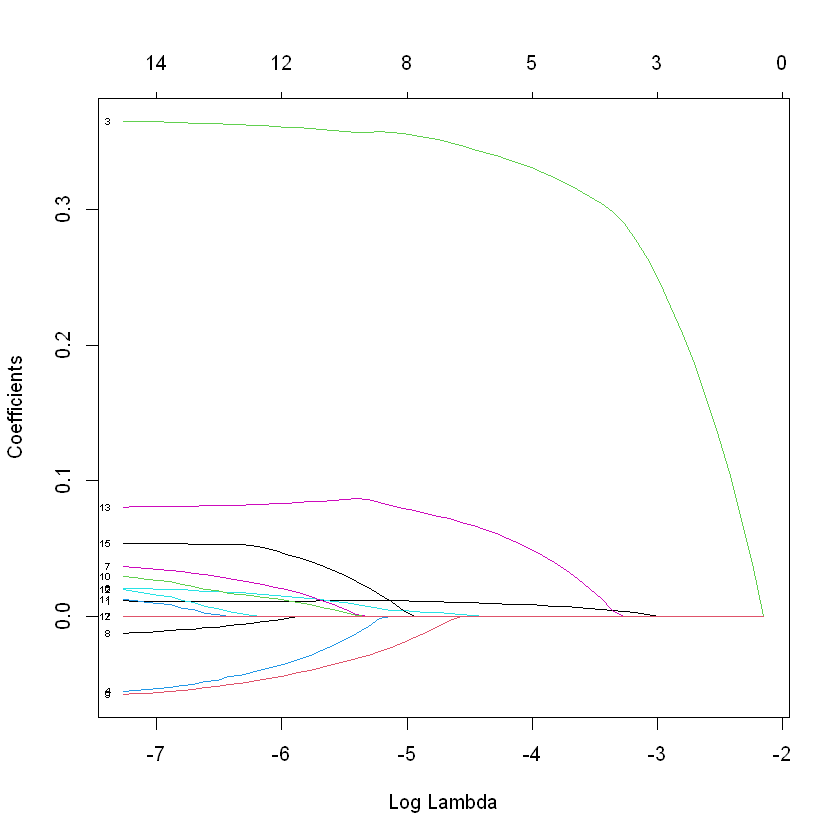

17 x 1 sparse Matrix of class "dgCMatrix"
                                1
age                  9.749135e-03
age_square           2.400645e-05
male                 3.422981e-01
TC_rcs_1             .           
TC_rcs_2             .           
TC_rcs_3             .           
log_LDLC             .           
albuminuria_moderate .           
albuminuria_severe   .           
CKD_stage_G3a        .           
CKD_stage_G3b        .           
CKD_stage_G4         .           
male_CKD_stage_G3a   6.399917e-02
male_CKD_stage_G3b   .           
male_CKD_stage_G4    .           
age_TC               .           
age_BMI_TC           1.899753e-05


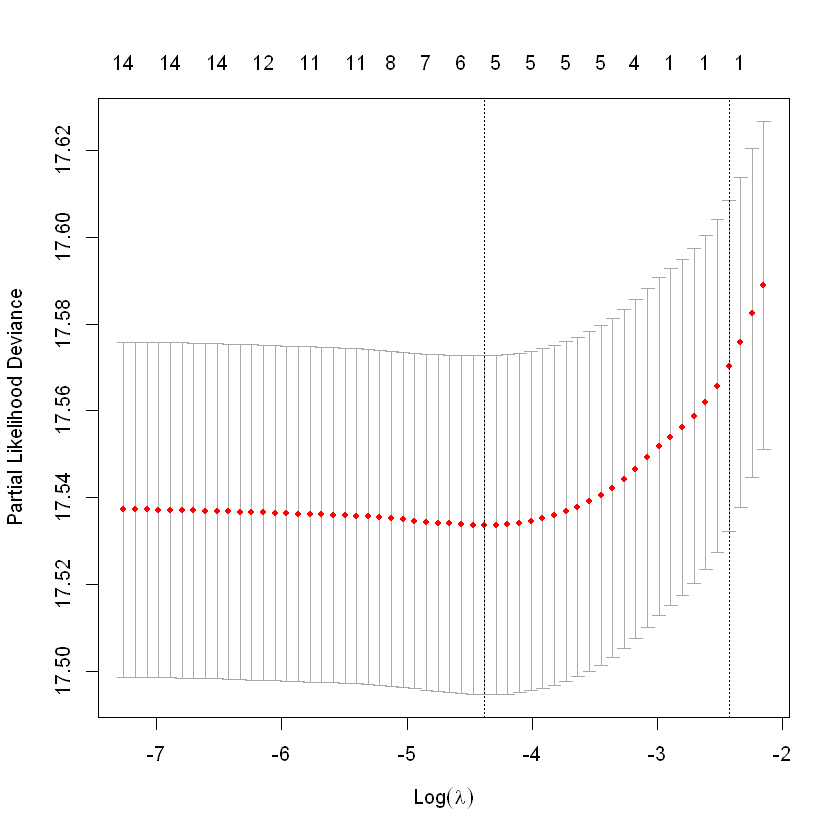

In [18]:
train_model_lasso <- Lasso_survival(data=dataset, time="AKI_time", status="AKI_status", predictors = predictors, lambda = "min")

上图1为LASSO筛选变量动态过程图，一条彩色线代表一个变量的回归系数β值的变化，x轴为惩罚值，x轴上方为在该值下的剩余变量数。随着λ增加，各变量的回归系数β在减小，有些变为0，说明该变量在此时对模型贡献微乎其微可以剔除。

上图2展示了Partial-likelihood deviance随Log(λ)变化曲线，图中给出了两个惩罚值λ：
1. Partial-likelihood deviance最小时的λ值，即lambda.min； 
2. 最小Partial-likelihood deviance一个标准误时对应的λ值，即lambda.1se

λ=lambda.min时，给出的是一个具备优良性能且自变量个数最少的模型，因此LASSO回归筛选出的变量为age, age_square, male, male_CKD_stage_G3a, age_BMI_TC。

综上，模型预测的精确性有时可以通过压缩或者令某些系数为0来提高，通过损失一点偏差（bias）来降低预测值的方差，从而可能提高整个模型预测的精确性。此外，当有大量的预测变量时，我们经常去筛选一个小的子集来进行模型构建，防止模型的过拟合，我们愿意损失一点解释度。以上为模型变量筛选常用的3种方法，在实际运用中还需要结合具体的临床背景对预测变量进一步筛选。

In [19]:
train_model_lasso

[1] "Surv(AKI_time, AKI_status) ~ age + age_square + male + male_CKD_stage_G3a + age_BMI_TC"

In [20]:
save.image("model_train_workspace.Rdata")